### Importing the necessary modules

We're using Matplotlib to plot each frame and moviepy to handle the animation. Matplotlib has animation capabilities, but I find moviepy much more simple and clear to use.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Ellipse
from moviepy.editor import VideoClip
from moviepy.video.io.bindings import mplfig_to_npimage

%matplotlib inline

### Loading data

We are using James' goal for Real versus Barcelona in April 2017. It is a great example of off the ball movement being important in football - an aspect which is mostly ignored by traditional stats, which focus on events, not positioning.

I collected the data myself from watchng the video replay again and again. Don't assume professional level accuracy. This is just for educational/entertainment purposes.

In [2]:
df = pd.read_csv('../datasets/james-vs-barcelona-positonal-data.csv', index_col=(0,1))
dfPlayers = pd.read_csv('../datasets/james-vs-barcelona-player-data.csv', index_col=0)

colors = {'attack': 'gray',
          'defense': '#00529F'}

fps = 20
length = 10

### Drawing the football field

(<matplotlib.figure.Figure at 0x2372d3c2710>,
 <matplotlib.axes._subplots.AxesSubplot at 0x2372d3cb1d0>)

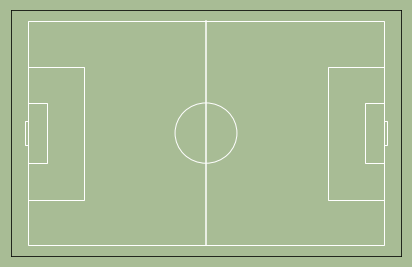

In [3]:
X_SIZE = 105.0
Y_SIZE = 68.0

BOX_HEIGHT = (16.5*2 + 7.32)/Y_SIZE*100
BOX_WIDTH = 16.5/X_SIZE*100

GOAL = 7.32/Y_SIZE*100

GOAL_AREA_HEIGHT = 5.4864*2/Y_SIZE*100 + GOAL
GOAL_AREA_WIDTH = 5.4864/X_SIZE*100


def draw_pitch():
    """Sets up field
    Returns matplotlib fig and axes objects.
    """
        
    fig = plt.figure(figsize=(X_SIZE/15, Y_SIZE/15))
    fig.patch.set_facecolor('#a8bc95')

    axes = fig.add_subplot(1, 1, 1, facecolor='#a8bc95')

    axes.xaxis.set_visible(False)
    axes.yaxis.set_visible(False)

    axes.set_xlim(0,100)
    axes.set_ylim(0,100)    

    axes = draw_patches(axes)
    
    return fig, axes

def draw_patches(axes):
    plt.xlim([-5,105])
    plt.ylim([-5,105])

    #pitch
    axes.add_patch(plt.Rectangle((0, 0), 100, 100,
                       edgecolor="white", facecolor="none", alpha=1))

    #half-way line
    axes.add_line(plt.Line2D([50, 50], [100, 0],
                    c='w'))
    
    #penalty areas
    axes.add_patch(plt.Rectangle((100-BOX_WIDTH, (100-BOX_HEIGHT)/2),  BOX_WIDTH, BOX_HEIGHT,
                       ec='w', fc='none'))
    axes.add_patch(plt.Rectangle((0, (100-BOX_HEIGHT)/2),  BOX_WIDTH, BOX_HEIGHT,
                               ec='w', fc='none'))                       
    
    #goal areas
    axes.add_patch(plt.Rectangle((100-GOAL_AREA_WIDTH, (100-GOAL_AREA_HEIGHT)/2),  GOAL_AREA_WIDTH, GOAL_AREA_HEIGHT,
                       ec='w', fc='none'))
    axes.add_patch(plt.Rectangle((0, (100-GOAL_AREA_HEIGHT)/2),  GOAL_AREA_WIDTH, GOAL_AREA_HEIGHT,
                               ec='w', fc='none'))                       

    #goals
    axes.add_patch(plt.Rectangle((100, (100-GOAL)/2),  1, GOAL,
                       ec='w', fc='none'))
    axes.add_patch(plt.Rectangle((0, (100-GOAL)/2),  -1, GOAL,
                               ec='w', fc='none'))                       
    
    
    #halfway circle
    axes.add_patch(Ellipse((50, 50), 2*9.15/X_SIZE*100, 2*9.15/Y_SIZE*100,
                                    ec='w', fc='none'))

    return axes
    
draw_pitch()

### Basic Animation

This code will output the basic animation, with the pitch, players and ball plotted. Each frame will then be enhanced with additional metrics in the next versions.

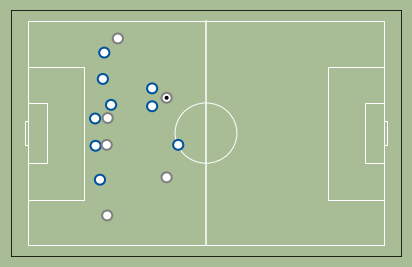

In [4]:
attackers = dfPlayers[dfPlayers.team=='attack'].index
defenders = dfPlayers[dfPlayers.team=='defense'].index

def draw_frame(t, display_num=False):
    f = int(t*fps)

    fig, ax = draw_pitch()
    
    dfFrame = df.loc[f]
    
    for pid in dfFrame.index:
        if pid==0:
            size = 0.6
            color='black'
            edge='black'
        else:
            size = 3
            color='white'
            if dfPlayers.loc[pid]['team'] == 'defense':
                edge=colors['defense']                        
            else:
                edge=colors['attack']
                
        ax.add_artist(Ellipse((dfFrame.loc[pid]['x'],
                               dfFrame.loc[pid]['y']),
                              size/X_SIZE*100, size/Y_SIZE*100,
                              edgecolor=edge,
                              linewidth=2,
                              facecolor=color,
                              alpha=1,
                              zorder=20))
        if display_num:
            plt.text(dfFrame.loc[pid]['x']-1,dfFrame.loc[pid]['y']-1.3,str(pid),fontsize=8, color='black', zorder=30)
    
    return fig, ax, dfFrame

anim = VideoClip(lambda x: mplfig_to_npimage(draw_frame(x)[0]), duration=length)

#to save the animation to a file, uncomment the next line 
#anim.to_videofile('working with positional data - version 1.mp4', fps=fps)

## 1. Numerical Superiority

As a first approach, let’s define the active zone as the smallest possible area between the goal line and a parallel line that includes the ball and maximizes the attacking superiority. The superiority metric will be the difference between attackers and defenders in the active zone.

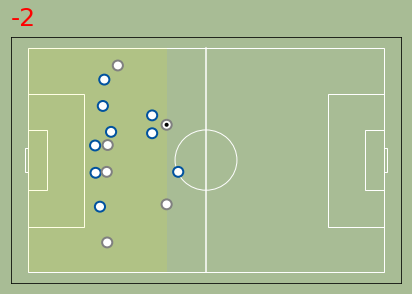

In [5]:
def count_players(dfFrame, pid):
    count = dfFrame.join(dfPlayers.team)[dfFrame['x']<=dfFrame.loc[pid]['x']].groupby('team').agg('count').max(axis=1)
    try:
        num_attack = count['attack']
    except KeyError:
        num_attack = 0
    try:
        num_defense = count['defense']
    except KeyError:
        num_defense = 0
    return (num_attack-num_defense)

def draw_area(t):
    fig, ax, dfFrame = draw_frame(t)

    
    maxX = dfFrame.loc[0]['x']
    superiority = count_players(dfFrame, 0)

    dfAttackers = dfFrame[(dfFrame.index.get_level_values(0).isin(attackers)) & (dfFrame['x']>maxX)]
    
    for pid, player in dfAttackers.iterrows():
        count = count_players(dfFrame, pid)
        if count>superiority:
            maxX = dfFrame.loc[pid]['x']
            superiority = count
        
    if superiority<0:
        color='red'
    else:
        color='black'
     
    plt.text(-5,110,str(superiority),fontsize=25, color=color)
    

    ax.add_patch(plt.Rectangle((0, 0), maxX, 100,
                       edgecolor="none", facecolor="yellow", alpha=0.1))

    return fig, ax


anim = VideoClip(lambda x: mplfig_to_npimage(draw_area(x)[0]), duration=length)

#to save the animation to a file, uncomment the next line 
#anim.to_videofile('working with positional data - version 2.mp4', fps=fps)

## 2. Marking

We start by identifying, for each defender, who the closest but farther from the goal attacker is. If the distance to that attacker is less than a certain marking distance (a few meters), we consider that the defender is marking the attacker. If no attacker is closer than that distance, then we assume the defender is marking a zone (a circle with the radius equal to the marking distance).

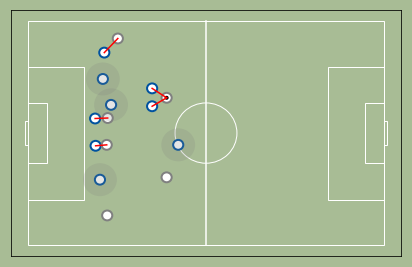

In [6]:
def closest_player(node, nodes):
    nodes = np.asarray(nodes)
    deltas = nodes - node
    dist = np.einsum('ij,ij->i', deltas, deltas)
    return dist.argsort()[0], dist[dist.argsort()[0]]

def draw_marking(t):
    fig, ax, dfFrame = draw_frame(t)

    dfAttackers = dfFrame[dfFrame.index.get_level_values(0).isin(attackers)]

    for pid in defenders:
        circle = False
        dfMarking = dfAttackers[dfAttackers['x']>(dfFrame.loc[pid]['x'])]

        
        if dfMarking.shape[0]>0:
            closest, closest_dist = closest_player(dfFrame.loc[pid].values,
                                                   dfMarking.values)

            if closest_dist<75:
                ax.add_line(plt.Line2D([dfFrame.loc[pid]['x'], dfMarking.iloc[closest]['x']],
                                       [dfFrame.loc[pid]['y'], dfMarking.iloc[closest]['y']],
                                       c='red', zorder=30))
            else:
                circle = True


        else:
            circle = True
            
        if circle:
            ax.add_artist(Ellipse((dfFrame.loc[pid]['x'],
                                   dfFrame.loc[pid]['y']),
                                  10/X_SIZE*100, 10/Y_SIZE*100,
                                  edgecolor='gray',
                                  linewidth=0,
                                  facecolor='gray',
                                  alpha=0.2,
                                  zorder=20))
                    
    return fig, ax

anim = VideoClip(lambda x: mplfig_to_npimage(draw_marking(x)[0]), duration=length)

#to save the animation to a file, uncomment the next line 
#anim.to_videofile('working with positional data - version 3.mp4', fps=fps)

## 3. Runs & Passing Options

We start by identifying whether  each attacker is marked or not. In this case, we are using the expected future attacker position to establish marking — that way, we enable forward runs to open passing options. We also use a different function for the distance (numpy based, so it should be more efficient). Also, for the OCD of you: yes, I know there's a bug in the distance calculation.  

We then plot lines between the player who has possession of the ball and all unmarked attackers.

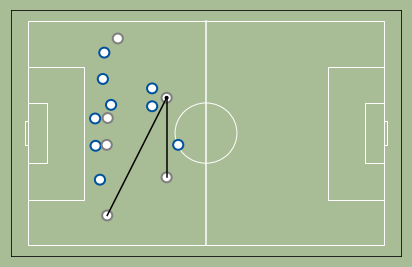

In [7]:
dfFuture = (df.unstack()+df.unstack().diff()*fps).stack()

def draw_passing(t):
    fig, ax, dfFrame = draw_frame(t)

    if ((dfFrame==dfFrame.loc[0]).sum(axis=1)>1).sum()>1:
        f = int(t*fps)
        dfFutureFrame = dfFuture.loc[f].join(dfPlayers.team) if len(dfFuture.loc[f])>0 else dfFrame.join(dfPlayers.team)

        marked_players = []

        for pid in defenders:
            dists = dfFutureFrame[(dfFutureFrame.team=='attack') & (dfFutureFrame.x>=dfFrame.loc[pid].x)
                                 ].apply(lambda x: np.linalg.norm(x[['x', 'y']]-dfFutureFrame.loc[pid][['x', 'y']]), axis=1)

            if dists.min()<12:
                marked_players.append(dists.idxmin())
    
        for pid in attackers:
            if pid not in marked_players:
                ax.add_line(plt.Line2D([dfFrame.loc[0]['x'], dfFutureFrame.loc[pid]['x']],
                                       [dfFrame.loc[0]['y'], dfFutureFrame.loc[pid]['y']],
                                       c='black', zorder=30))

                
    return fig, ax

anim = VideoClip(lambda x: mplfig_to_npimage(draw_passing(x)[0]), duration=length)

#to save the animation to a file, uncomment the next line 
#anim.to_videofile('working with positional data - version 4.mp4', fps=fps)

## 4. Passing Quality

For this metric, we show the actual pass over the passing options (reused from the last metric) at the moment the pass was made.

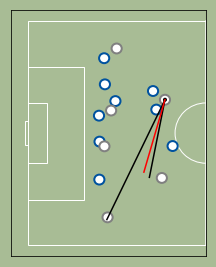

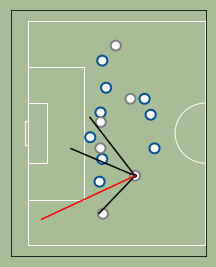

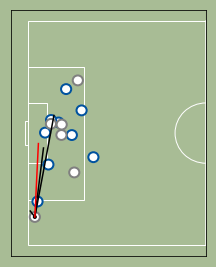

In [8]:
dfX = df.unstack()['x']

dfChange = df.unstack()[np.sum((dfX.apply(lambda x: x/dfX[0])==1) !=
                               (dfX.shift(-1).apply(lambda x: x/dfX.shift(-1)[0])==1)
                               ,axis=1)>0]

for i in range(1,dfChange.shape[0]-2, 2):
    f = dfChange.index[i]
    f2 = dfChange.index[i+1]
    fig, ax = draw_passing(f/fps)
    ax.add_line(plt.Line2D([dfChange.loc[f,('x', 0)], dfChange.loc[f2,('x', 0)]],
                           [dfChange.loc[f,('y', 0)], dfChange.loc[f2,('y', 0)]],
                           c='red', zorder=30))
    
    fig.set_size_inches(X_SIZE/15/2, Y_SIZE/15)
    ax.set_xlim(-5,50)
